# Figure 7 and S2: ECCOv4 Wind Stress Variance

This notebook will reproduce Figures 7 and S2 from  E. Boland et al. 2025 (doi to come). This requires input datafiles of ECCOv4r4 ocean wind stress - please see the README for details.

Please attribute any plots or code from this notebook using the DOI from Zenodo: TO COME

E Boland Jan 2025 [emmomp@bas.ac.uk](email:emmomp@bas.ac.uk)

In [1]:
import xarray as xr
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.colors as colors
%matplotlib inline
import scipy.stats as stats
import cartopy.crs as ccrs
import sys
sys.path.insert(0,'/users/emmomp/Python/ECCOv4-py')
import ecco_v4_py as ecco
import utils as ut
import calendar
from inputs import DATA_DIR, EXPDIR, adj_diag_map, ecco_grid
import warnings
warnings.filterwarnings('ignore')

In [3]:
xmin,xmax,ymin,ymax=(-2766791.253073855,
 3358349.2597455736,
 -3566791.253073855,
 3458349.2597455736)
proj_dict={'projection_type':'ortho','user_lon_0':-45,'user_lat_0':70}
my_projn = ccrs.Orthographic(central_longitude=-45,central_latitude=70)
[section_pt1,section_pt2]=ecco.get_section_endpoints('Denmark Strait')

In [4]:
ds_ca_monvar=xr.open_dataset(f'{DATA_DIR}/eccov4_varbybasin.nc')
ds_climanom=xr.open_dataset(f'{EXPDIR}/fwd_26y/exf_climanoms.nc')

In [9]:
masks=ut.load_canari_masks()

get_basin_name:  ['atl'] /users/emmomp/Python/ECCOv4-py/binary_data
load_binary_array: loading file /users/emmomp/Python/ECCOv4-py/binary_data/basins.data
load_binary_array: data array shape  (1170, 90)
load_binary_array: data array type  >f4
llc_compact_to_faces: dims, llc  (1170, 90) 90
llc_compact_to_faces: data_compact array type  >f4
llc_faces_to_tiles: data_tiles shape  (13, 90, 90)
llc_faces_to_tiles: data_tiles dtype  >f4
shape after reading 
(13, 90, 90)
get_basin_name:  ['arct'] /users/emmomp/Python/ECCOv4-py/binary_data
load_binary_array: loading file /users/emmomp/Python/ECCOv4-py/binary_data/basins.data
load_binary_array: data array shape  (1170, 90)
load_binary_array: data array type  >f4
llc_compact_to_faces: dims, llc  (1170, 90) 90
llc_compact_to_faces: data_compact array type  >f4
llc_faces_to_tiles: data_tiles shape  (13, 90, 90)
llc_faces_to_tiles: data_tiles dtype  >f4
shape after reading 
(13, 90, 90)
get_basin_name:  ['hudson'] /users/emmomp/Python/ECCOv4-py/bina

In [10]:
masks_plot_map=['gland','natl','arct','norw','hudson', 'north', 'baffin','barents']
mask_da=xr.zeros_like(masks['global'])
for ib,basin in enumerate(masks_plot_map):
    mask_da=mask_da+masks[basin]*(ib+1)
mask_da=xr.where(mask_da==0,np.nan,mask_da)

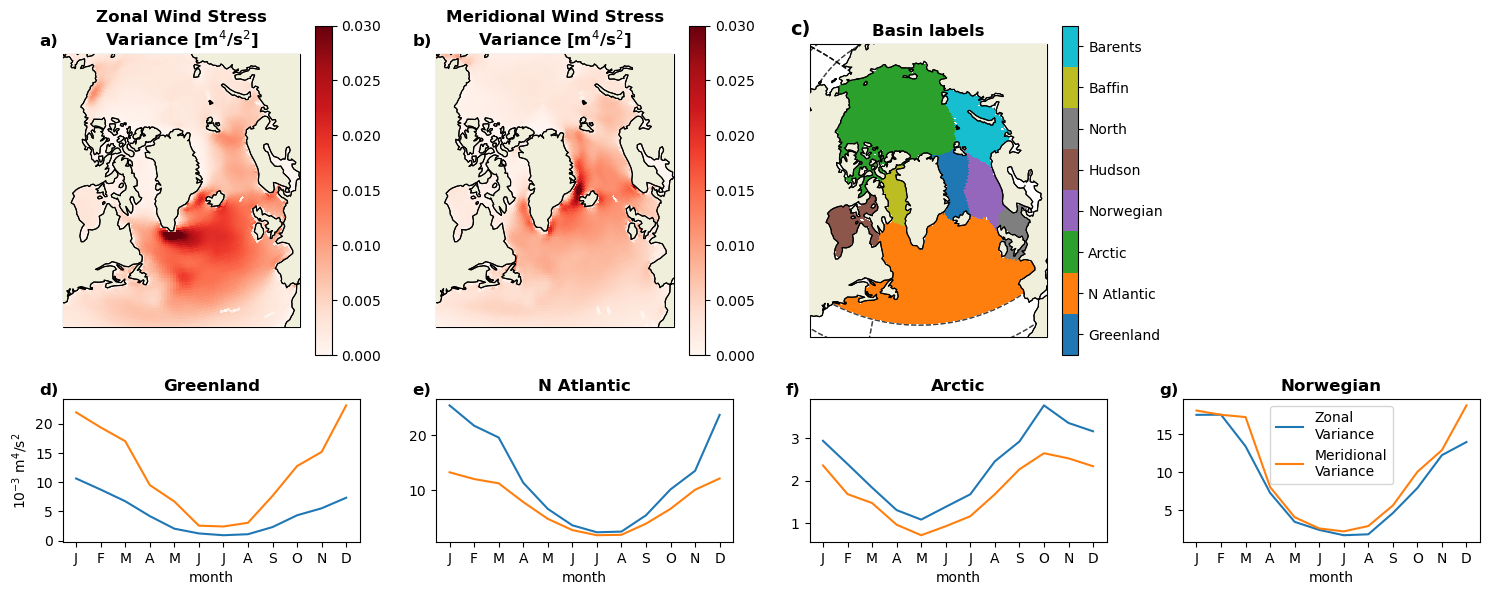

In [13]:
masks_plot=['gland','natl','arct','norw']
cmap=plt.get_cmap('tab10')(np.linspace(0,1,8))
new_cmap = colors.ListedColormap(cmap)

var_clims=dict(zip(adj_vars,[15e3,2e-14,0.03,0.03]))
var_label=['Zonal','Meridional']

plt.figure(figsize=[15,6])

pp=1
for iv,var in enumerate(adj_vars[2:]):
    ax=plt.subplot2grid((3, 4), (0, pp-1), rowspan=2,projection=my_projn)
    var_var=ds_climanom[adj_diag_map[var]].sel(time=slice('1996-01-01',None)).var('time')
    [f,ax,p]=ut.plot_ecco(ecco_grid,var_var,ax=ax,
                       **proj_dict,rasterized=True,
                       cmin=0,cmax=var_clims[var],cmap='Reds'
                      )    
    ax.set_extent([xmin,xmax,ymin,ymax], crs=my_projn)
    plt.text(-0.1,1.03,f'{chr(96+pp)})',transform=plt.gca().transAxes,fontsize=12,fontweight='bold')
    plt.title(f'{var_label[iv]} Wind Stress\nVariance [m$^4$/s$^2$]',fontsize=12,fontweight='bold')
    pp+=1

ax=plt.subplot2grid((3, 4), (0, pp-1), rowspan=2,projection=my_projn)
[f,ax,p]=ut.plot_ecco(ecco_grid,mask_da,cmap=new_cmap,cmin=0.5,cmax=8.5,**proj_dict,show_colorbar=False,ax=ax,rasterized=True)
sm = plt.cm.ScalarMappable(cmap=new_cmap)
sm._A = []
cb = plt.colorbar(sm,ax=ax)
cb.set_ticks(list(np.arange(1/16,17/16,1/8)))
ticks=cb.ax.set_yticklabels([masks_labels[m] for m in masks_plot_map])
ax.set_extent([-3e6,3.5e6,-3.5e6,4.5e6], crs=my_projn)
plt.text(-0.08,1.03,f'{chr(96+pp)})',transform=ax.transAxes,fontsize=14,fontweight='bold')
plt.title('Basin labels',fontsize=12,fontweight='bold')

pp=5
for im,mask in enumerate(masks_plot):
    ax=plt.subplot2grid((3, 4), (2, im))
    (1e3*ds_ca_monvar['oceTAUU']).sel(stat='sum',mask=mask).plot(ax=ax)
    (1e3*ds_ca_monvar['oceTAUV']).sel(stat='sum',mask=mask).plot(ax=ax)
    if im==0:
        plt.ylabel('10$^{-3}$ m$^4$/s$^2$')
    else:
        plt.ylabel('')
    plt.title(masks_labels[mask],fontsize=12,fontweight='bold')
    plt.text(-0.08,1.03,f'{chr(95+pp)})',transform=ax.transAxes,fontsize=12,fontweight='bold')
    if im==3:
        plt.legend([f'Zonal\nVariance',f'Meridional\nVariance'])
    plt.xticks(range(1,13),[m[0] for m in mth])
    pp+=1

plt.tight_layout()
plt.savefig(f'../plots/fig7_varseas_basinmap.pdf')

In [5]:
Niland=(ecco_grid.XC>-20)&(ecco_grid.XC<-11)&(ecco_grid.YC>64.5)&(ecco_grid.YC<68)
Siland=(ecco_grid.XC>-25)&(ecco_grid.XC<-15)&(ecco_grid.YC>62)&(ecco_grid.YC<65)
Ntauu=(ds_climanom['oceTAUU']*ecco_grid.rA).where(Niland).sum(['tile','j','i'])/ecco_grid.rA.where(Niland).sum(['tile','j','i'])
Stauu=(ds_climanom['oceTAUU']*ecco_grid.rA).where(Siland).sum(['tile','j','i'])/ecco_grid.rA.where(Siland).sum(['tile','j','i'])

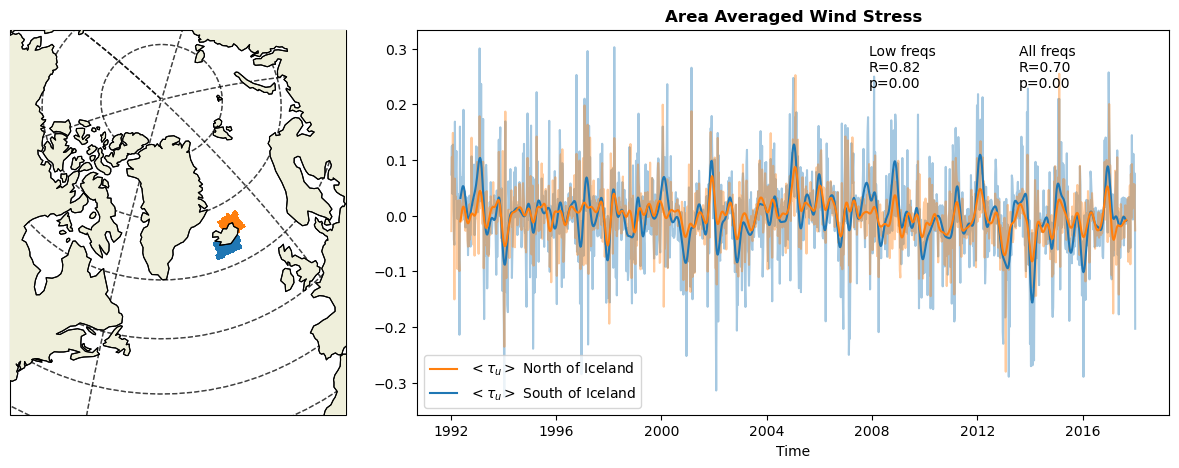

In [14]:
colors=plt.get_cmap('tab10')
plt.figure(figsize=[15,5])
ax=plt.subplot2grid((1, 3), (0, 0), colspan=1,projection=my_projn)
da=2*Niland.astype('int')+Siland.astype('int')
da_plot=xr.where(da==0,np.nan,da)
[f,ax,p]=ut.plot_ecco(ecco_grid,da_plot,**proj_dict,cmap='tab10',cmin=1,cmax=11,ax=ax,show_colorbar=False)
ax.set_extent([xmin,xmax,ymin,ymax], crs=my_projn)

[r_m,p_m]=stats.pearsonr(Ntauu.sel(time=slice('1996-01-01',None)),Stauu.sel(time=slice('1996-01-01',None)))
[r_y,p_y]=stats.pearsonr(ut.butter_ufunc(Ntauu,18,'time')[18:-18],ut.butter_ufunc(Stauu,18,'time')[18:-18])
ax=plt.subplot2grid((1, 3), (0, 1), colspan=2)
Stauu.plot(alpha=0.4,color=colors(0),ax=ax)
Ntauu.plot(alpha=0.4,color=colors(1),ax=ax)
p2=ut.butter_ufunc(Stauu,18,'time')[18:-18].plot(color=colors(0))[0]
p1=ut.butter_ufunc(Ntauu,18,'time')[18:-18].plot(color=colors(1))[0]
plt.legend([p1,p2],['$<\\tau_u>$ North of Iceland','$<\\tau_u>$ South of Iceland'])
plt.title('Area Averaged Wind Stress',fontsize=12,fontweight='bold')
plt.text(0.8,0.85,f'All freqs\nR={r_m:1.2f}\np={p_m:1.2f}',transform=ax.transAxes)
plt.text(0.6,0.85,f'Low freqs\nR={r_y:1.2f}\np={p_y:1.2f}',transform=ax.transAxes)
plt.savefig(f'../plots/supfig_IcelandWindStress.pdf')